# Single-cell workflow (Scanpy)

This notebook loads the concatenated h5ad files and runs a standard Scanpy workflow.


In [70]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from pathlib import Path


import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi

from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from scipy.sparse import issparse

sc.settings.verbosity = 3


import sys
from pathlib import Path

repo_root = Path.cwd().resolve().parent  # if notebook is in analysis/
sys.path.append(str(repo_root / "scripts"))

from plot_spatial_compact_fast import plot_spatial_compact_fast




## Load concatenated data


In [73]:
h5ad_dir = Path('/Volumes/processing2/nature-dev-mouse-reanalysis/data/h5ad')
h5ad_paths = sorted(p for p in h5ad_dir.glob('*.h5ad') if not p.name.startswith('._'))
print(f'Found {len(h5ad_paths)} h5ad files in {h5ad_dir}')
adatas = [sc.read_h5ad(p) for p in h5ad_paths]
adata = sc.concat(adatas, join='outer', merge='unique', label='section', index_unique='-')
adata


Found 27 h5ad files in /Volumes/processing2/nature-dev-mouse-reanalysis/data/h5ad


AnnData object with n_obs × n_vars = 324191 × 119
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'section', 'sample_id', 'source_dir'

In [75]:
adata.obs

x             y  cluster  n_transcripts  \
cell                                                                     
CR7172c4560-1-0     16003.500000  11683.277778        3             18   
CR7172c4560-10-0    15522.133333  12218.283333        3             60   
CR7172c4560-100-0   15989.437500  12318.593750        2             32   
CR7172c4560-1000-0  17017.785714  14720.714286        2             14   
CR7172c4560-1001-0  17627.315789  14141.894737        2             19   
...                          ...           ...      ...            ...   
CR5df0e342d-995-26   4529.777778  12294.222222        2             27   
CR5df0e342d-996-26   4186.979167  12714.250000        2             48   
CR5df0e342d-997-26   5591.000000  11377.807692        2             26   
CR5df0e342d-998-26   7264.612903   9655.290323        2             31   
CR5df0e342d-999-26   4254.486486  12685.405405        2             37   

                     density  elongation     area  avg_confidence  \
cell                                                                
CR7172c4560-1-0     0.005448       2.466   3304.0          0.9905   
CR7172c4560-10-0    0.005629       1.735  10660.0          0.9774   
CR7172c4560-100-0   0.007657       2.015   4179.0          0.9931   
CR7172c4560-1000-0  0.005922       2.458   2364.0          0.9933   
CR7172c4560-1001-0  0.003987       2.327   4765.0          0.9856   
...                      ...         ...      ...             ...   
CR5df0e342d-995-26  0.010690       1.244   2526.0          0.9985   
CR5df0e342d-996-26  0.011030       2.141   4352.0          0.9987   
CR5df0e342d-997-26  0.005742       1.116   4528.0          0.9948   
CR5df0e342d-998-26  0.005299       2.090   5850.0          0.9853   
CR5df0e342d-999-26  0.009676       1.189   3824.0          0.9985   

                    avg_assignment_confidence  max_cluster_frac  lifespan  \
cell                                                                        
CR7172c4560-1-0                        0.7889          0.888889        50   
CR7172c4560-10-0                       0.9287          0.966667        50   
CR7172c4560-100-0                      0.8775          1.000000        50   
CR7172c4560-1000-0                     0.8629          1.000000        50   
CR7172c4560-1001-0                     0.8968          0.947368        50   
...                                       ...               ...       ...   
CR5df0e342d-995-26                     0.8007          1.000000        50   
CR5df0e342d-996-26                     0.8183          1.000000        50   
CR5df0e342d-997-26                     0.8046          1.000000        50   
CR5df0e342d-998-26                     0.7845          1.000000        50   
CR5df0e342d-999-26                     0.7092          1.000000        50   

                   section    sample_id  \
cell                                      
CR7172c4560-1-0          0  section_02A   
CR7172c4560-10-0         0  section_02A   
CR7172c4560-100-0        0  section_02A   
CR7172c4560-1000-0       0  section_02A   
CR7172c4560-1001-0       0  section_02A   
...                    ...          ...   
CR5df0e342d-995-26      26  section_18E   
CR5df0e342d-996-26      26  section_18E   
CR5df0e342d-997-26      26  section_18E   
CR5df0e342d-998-26      26  section_18E   
CR5df0e342d-999-26      26  section_18E   

                                                           source_dir  
cell                                                                   
CR7172c4560-1-0     /Volumes/processing2/nature-dev-mouse-reanalys...  
CR7172c4560-10-0    /Volumes/processing2/nature-dev-mouse-reanalys...  
CR7172c4560-100-0   /Volumes/processing2/nature-dev-mouse-reanalys...  
CR7172c4560-1000-0  /Volumes/processing2/nature-dev-mouse-reanalys...  
CR7172c4560-1001-0  /Volumes/processing2/nature-dev-mouse-reanalys...  
...                                                               ...  
CR5df0e342d-995-26  /Volumes/pro

## QC metrics and filtering


In [76]:
# Basic QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# Inspect thresholds before filtering
adata.obs[['n_genes_by_counts', 'total_counts']].describe()


n_genes_by_counts   total_counts
count      324191.000000  324191.000000
mean           16.365423      38.522257
std             6.160800      28.418823
min             1.000000       1.000000
25%            12.000000      18.000000
50%            16.000000      30.000000
75%            20.000000      51.000000
max            49.000000     277.000000

In [77]:
# Example filters (adjust based on dataset)
sc.pp.filter_cells(adata, min_genes=5)
sc.pp.filter_genes(adata, min_cells=3)

# Filter out high-mito cells (adjust threshold)
adata


filtered out 2453 cells that have less than 5 genes expressed


AnnData object with n_obs × n_vars = 321738 × 119
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'section', 'sample_id', 'source_dir', 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

## Normalization and feature selection


In [78]:
adata.obsm['spatial'] = np.array(adata.obs[['x', 'y']])

In [79]:
adata.layers['counts'] = adata.X.copy()

In [80]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['normalized'] = adata.X.copy()

sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')
adata = adata[:, adata.var.highly_variable].copy()

sc.pp.scale(adata, max_value=10)

adata


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 321738 × 119
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'section', 'sample_id', 'source_dir', 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'
    layers: 'counts', 'normalized'

## Dimensionality reduction and clustering


In [81]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata, min_dist=0.1)
adata


computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:43)


AnnData object with n_obs × n_vars = 321738 × 119
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'section', 'sample_id', 'source_dir', 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

Clustering at resolution 0.5...
running Leiden clustering
    finished: found 23 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:01:10)
Done.


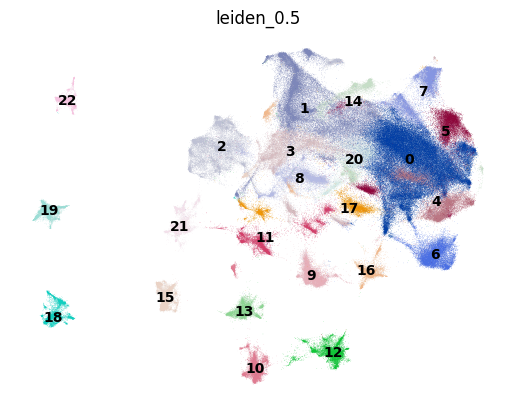

Clustering at resolution 1...
running Leiden clustering
    finished: found 37 clusters and added
    'leiden_1', the cluster labels (adata.obs, categorical) (0:01:33)
Done.


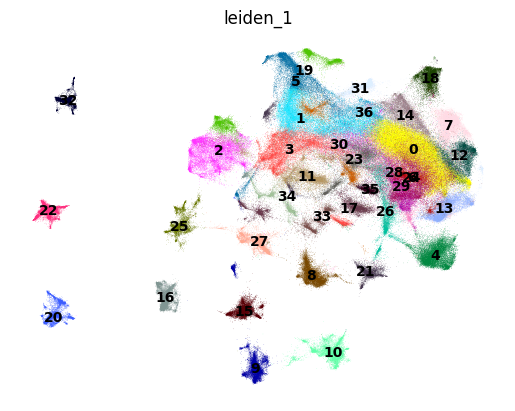

Clustering at resolution 2...
running Leiden clustering
    finished: found 51 clusters and added
    'leiden_2', the cluster labels (adata.obs, categorical) (0:01:45)
Done.


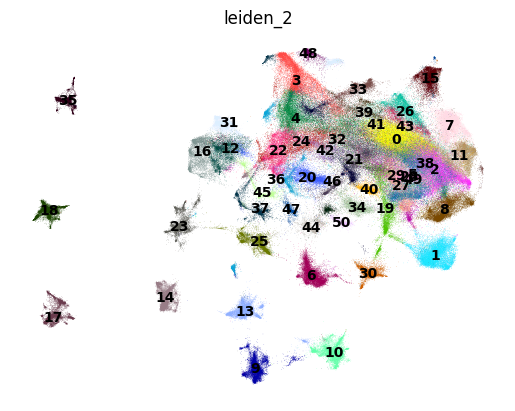

In [82]:
resolutions = [0.5, 1, 2]

for resolution in resolutions:
    key = f'leiden_{resolution}'

    if key in adata.obs.columns:
        print(f"Skipping {resolution}: {key} already exists.")
    else:
        print(f"Clustering at resolution {resolution}...")
        sc.tl.leiden(adata, resolution=resolution, key_added=key)
        print("Done.")

    # plot UMAP
    sc.pl.umap(adata, color=key, legend_loc='on data', frameon=False)

## Marker genes


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


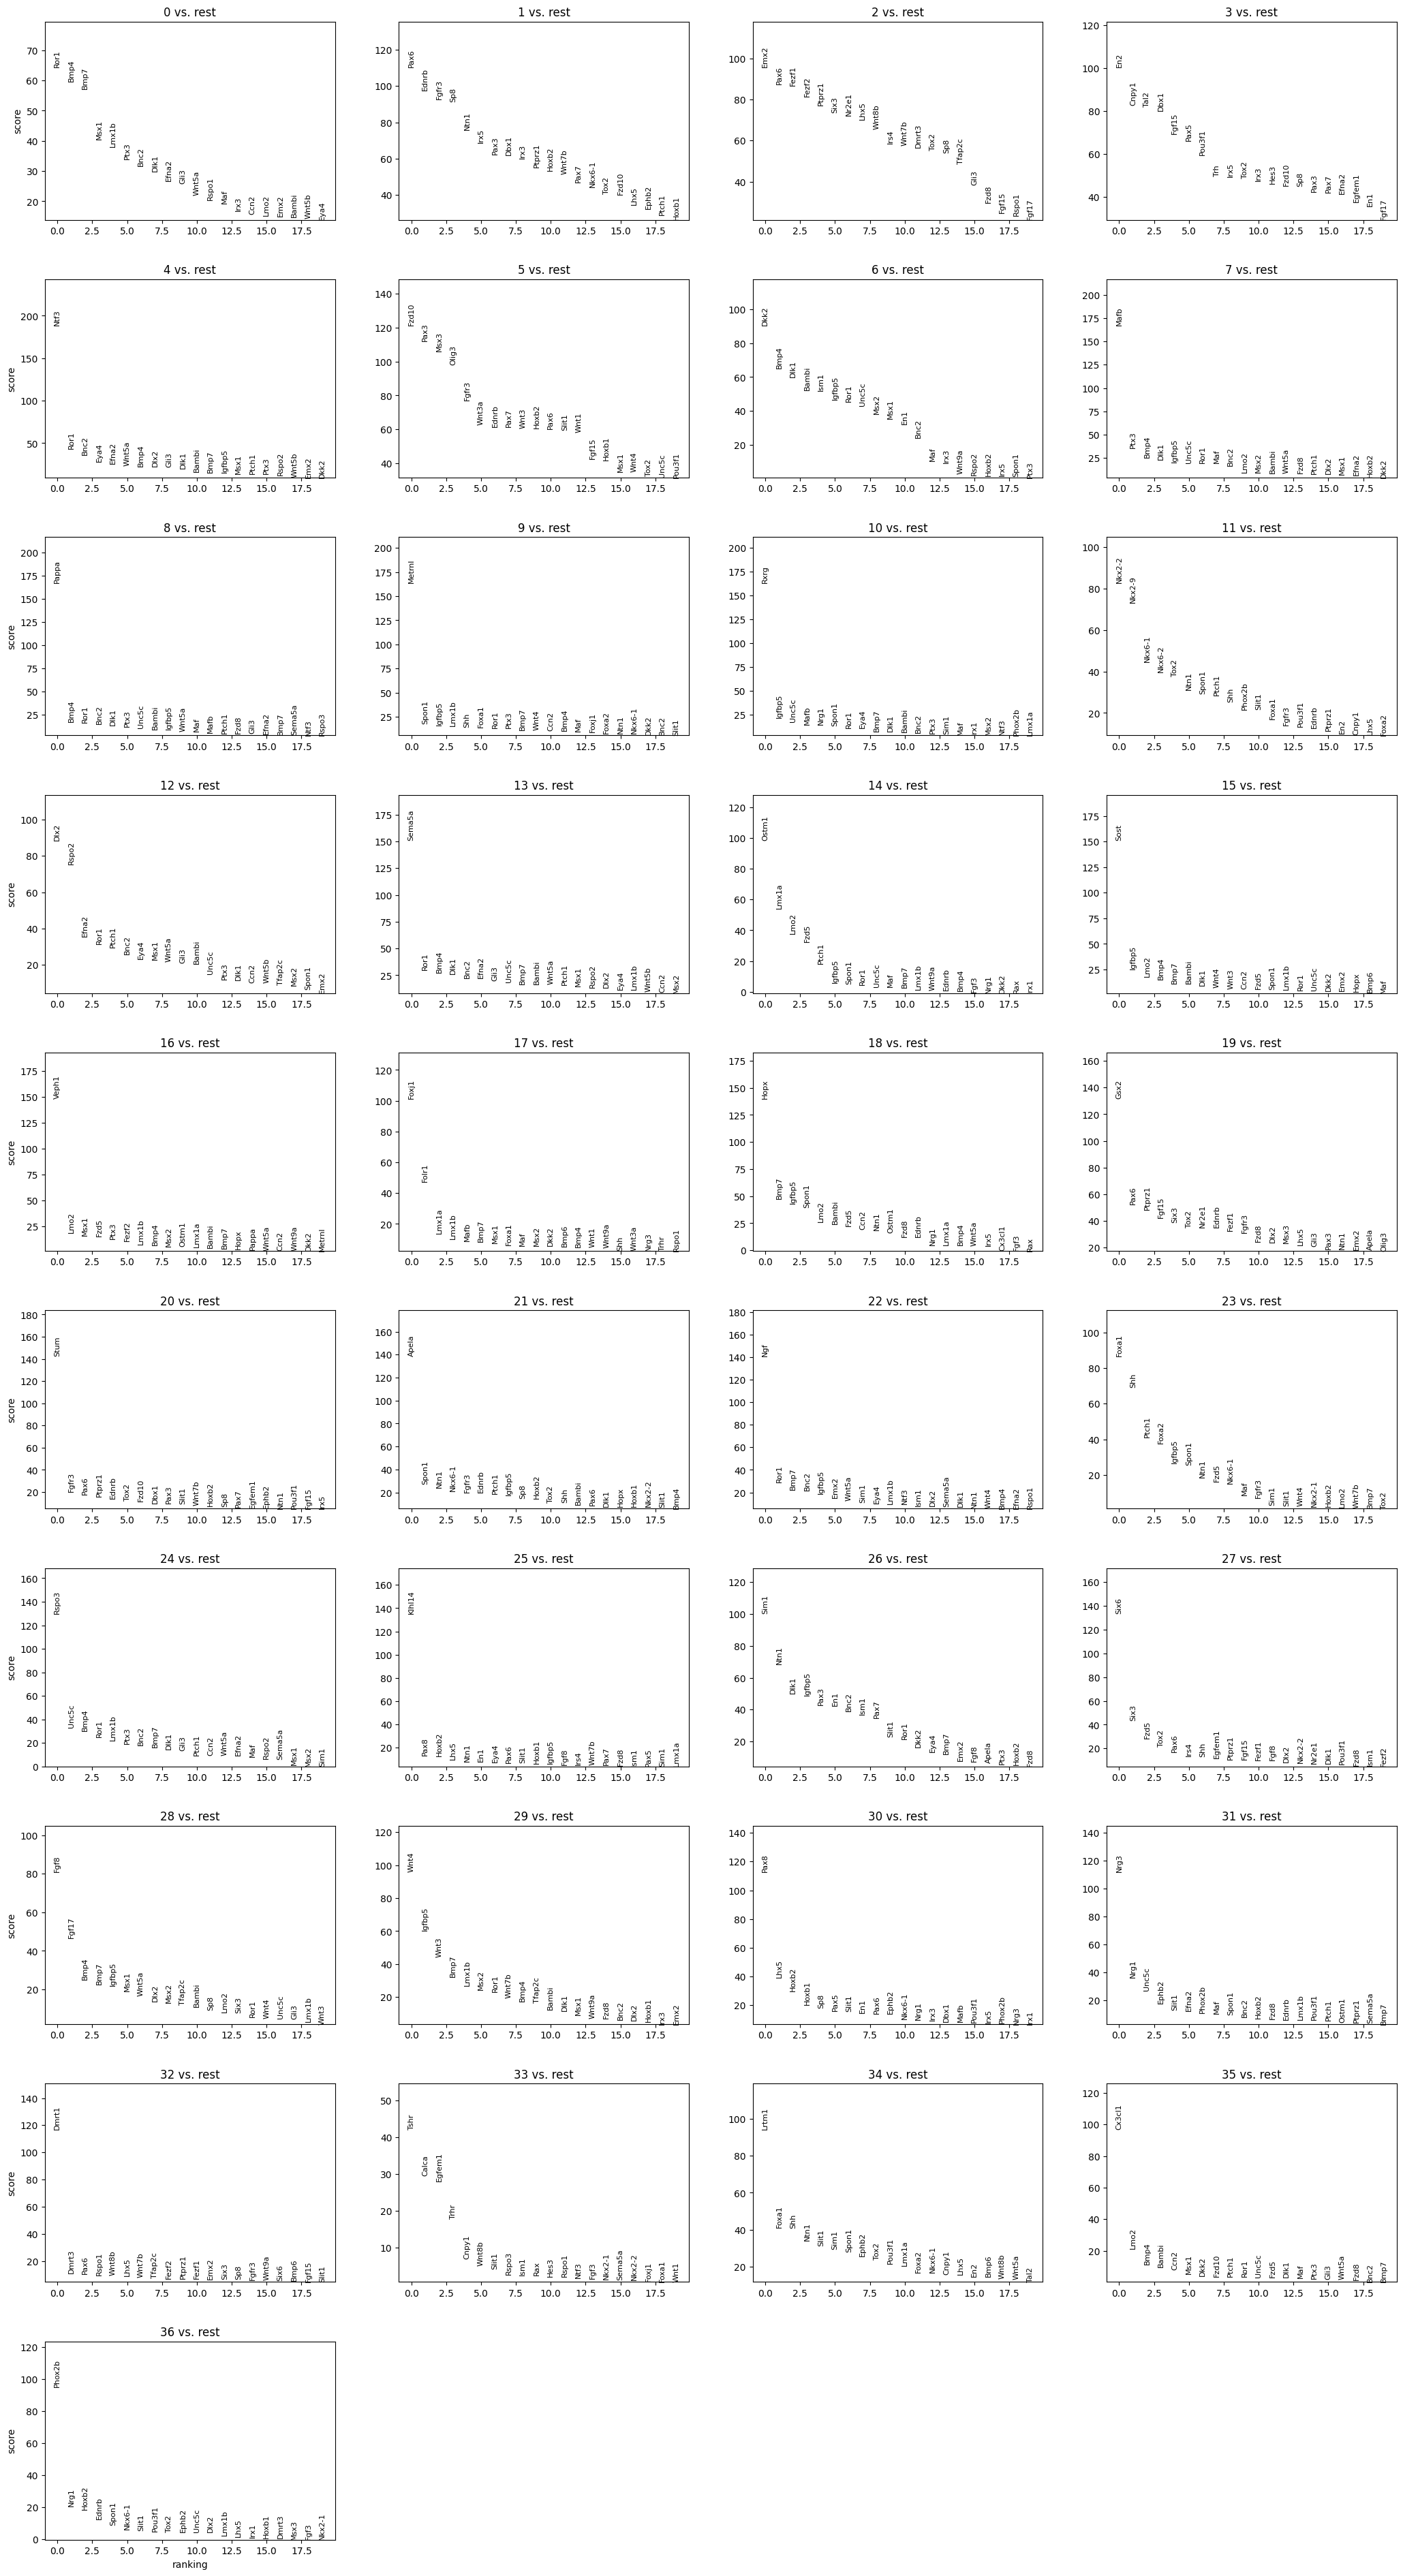

In [86]:
sc.tl.rank_genes_groups(adata, groupby='leiden_1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


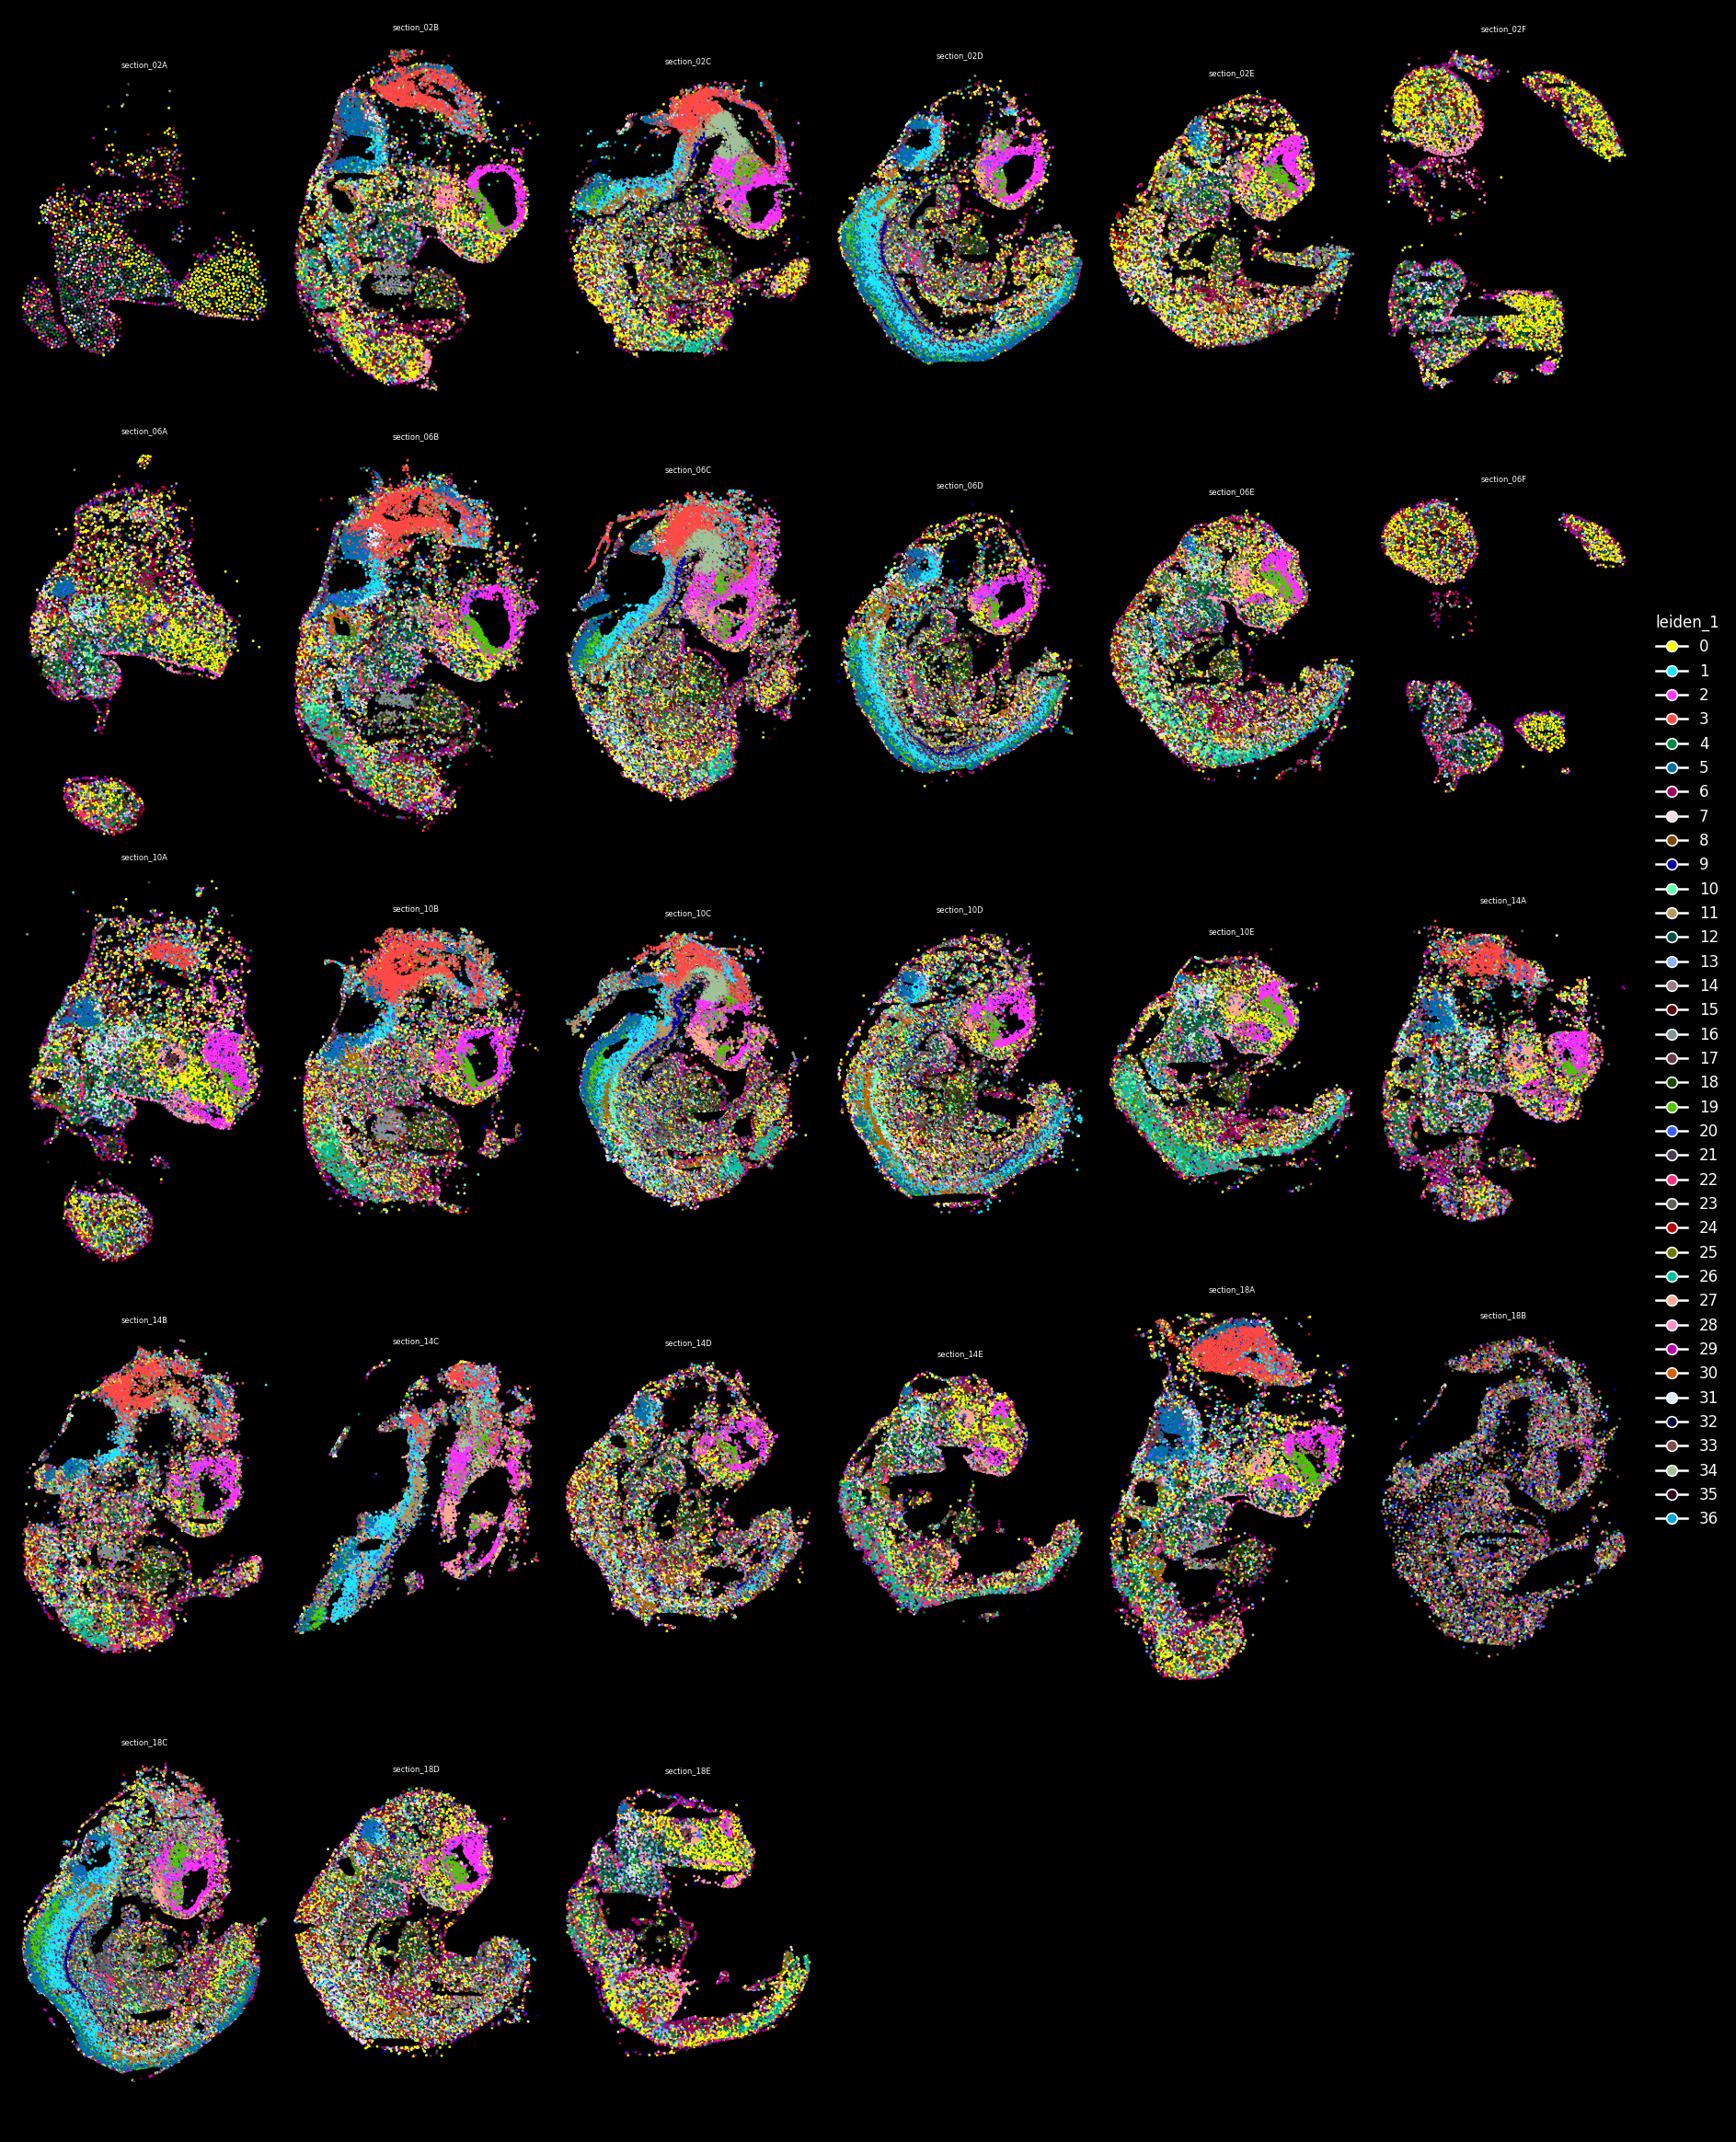

In [87]:
# usage
plot_spatial_compact_fast(
    adata,
    color="leiden_1",
    groupby="sample_id",
    spot_size=3,
    cols=6,
    height=20,
    legend_col_width=1.0,
    background="black",

)

## Save processed object


In [88]:
outdir = Path('/Volumes/processing2/nature-dev-mouse-reanalysis')
out_path = outdir / 'ad_all_processed.h5ad'
adata.write(out_path)
out_path


PosixPath('/Volumes/processing2/nature-dev-mouse-reanalysis/ad_all_processed.h5ad')